# Distributed Machine Learning with Dask

## Dashboard Setup Steps

![dask layout](dask-layout.png)

* Run the code below this cell first
* Open the Dask extension tab (left side) 
* Click on "Task Stream" and "Progress" buttons
* Lay out the panels as you like 
* Run rest of the notebook!

In [1]:
from dask.distributed import Client, progress
from joblib import parallel_backend

client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.192.2:8787/status,
Dashboard: http://192.168.192.2:8787/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://192.168.192.2/4910/1,Workers: 1
Dashboard: http://192.168.192.2:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://192.168.192.2/4910/4,Total threads: 4
Dashboard: http://192.168.192.2:35113/status,Memory: 1.86 GiB
Nanny: None,




## References

**Data Science with Python and Dask**  ([online access via SNU library](https://learning.oreilly.com/library/view/data-science-with/9781617295607/))

[![asdf](https://learning.oreilly.com/covers/urn:orm:book:9781617295607/400w/)](https://learning.oreilly.com/library/view/data-science-with/9781617295607/)

* [examples.dask.org](https://examples.dask.org/) ([Github repo](https://github.com/dask/dask-examples))
* [scikit-learn's recognizing hand-written digits](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)
* [scikit-learn supervised learning user guides](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)

## Reading HDF5 Data File

In [2]:
%matplotlib inline

import wget
import h5py

# fname = wget.download('https://sandbox.zenodo.org/record/1027635/files/mnist.hdf5?download=1')
fname = 'mnist.hdf5'
f = h5py.File(fname)

## Introducing Dask

https://learning.oreilly.com/library/view/data-science-with/9781617295607/c02.xhtml#h2-295607c02-0003

In [3]:
import numpy as np
import pandas as pd

import dask.array as da
from dask_ml.model_selection import train_test_split

X = da.from_array(f['training-images'][0:10000], chunks=1000)
y = da.from_array(f['training-labels'][0:10000], chunks=1000)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=0)

In [4]:
X_train

dask.array<concatenate, shape=(5000, 784), dtype=uint8, chunksize=(500, 784), chunktype=numpy.ndarray>

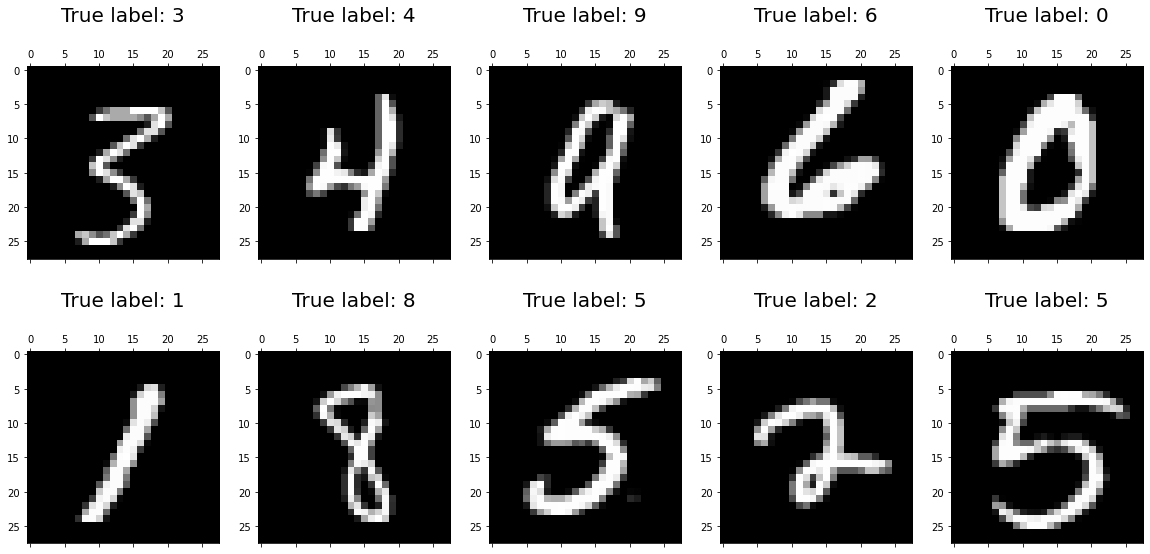

In [5]:
def plot_digits(X_, y_, num_figs, y_caption='True label'):

    from matplotlib.pyplot import figure
    from numpy import ceil

    num_rows = ceil(num_figs/5).astype(int)

    fig = figure(figsize=(20, 4.8*num_rows))

    # for j, ((i, img), (i, lab)) in enumerate(zip(X_, y_)):
    for j, (img, lab) in enumerate(zip(X_, y_)):

        tf = fig.add_subplot(num_rows, 5, j+1)
        tf.matshow(img.reshape((28, -1)), cmap='gray')
        tf.set_title('%s: %s\n' % (y_caption, lab.compute()), fontsize = 20)

        if j+1 == num_figs: break

plot_digits(X_train, y_train, 10)

## Housekeeping variables

Following variables will collect trained estimators and predicted labels (and cluster assignments) for comparison.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay


est = dict()  # estimators
pred = dict() # predictions

## Classification with Random Forest



In [7]:
est['rf-skl'] = RandomForestClassifier()
%time est['rf-skl'].fit(X_train, y_train)
pred['rf-skl'] = est['rf-skl'].predict(X_test)

print(
    'Out of sample prediction accuracy:',
    (pred['rf-skl'] == y_test).mean().compute(),
    '%'
    )

CPU times: user 5.24 s, sys: 100 ms, total: 5.34 s
Wall time: 5.03 s
Out of sample prediction accuracy: 0.9366 %


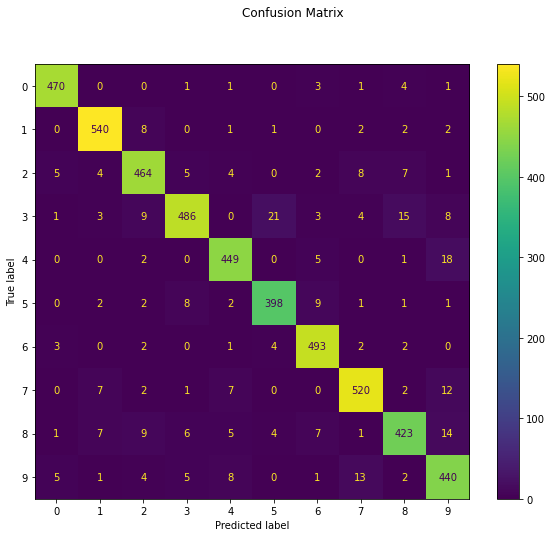

In [8]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, pred['rf-skl'])
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.set_size_inches((10, 8))

## Taking advantage of distributed computing

## Classification with Random Forest - Dask Backend

In [9]:
with parallel_backend('dask'):

    est['rf-dask'] = RandomForestClassifier()

    %time est['rf-dask'].fit(X_train, y_train)

    pred['rf-dask'] = est['rf-dask'].predict(X_test)

print(
    'Out of sample prediction accuracy:',
    (pred['rf-dask'] == y_test).mean().compute(),
    '%'
    )

CPU times: user 5.91 s, sys: 148 ms, total: 6.06 s
Wall time: 2.34 s
Out of sample prediction accuracy: 0.9366 %


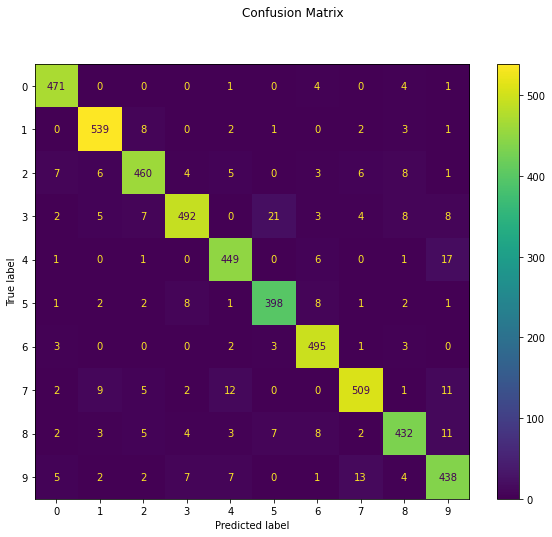

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, pred['rf-dask'])
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.set_size_inches((10, 8))

## Classification with Random Forest + Hyperparameter optimization

* [distributed scikit-learn with joblib](https://ml.dask.org/joblib.html)
* [hyperparameter optimization with dask](https://examples.dask.org/machine-learning/hyperparam-opt.html)
* [GridSearchCV](https://ml.dask.org/modules/generated/dask_ml.model_selection.GridSearchCV.html)

### Scikit-learn's GridSearchCV

In [11]:
from sklearn.model_selection import GridSearchCV as skl_gscv

estimator = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],
}

grid_search = skl_gscv(estimator, 
                param_grid=param_grid,
                return_train_score=False,
                cv=3)

%time grid_search.fit(X_train, y_train)

est['rf-dask-opt'] = grid_search.best_estimator_

pred['rf-dask-opt'] = est['rf-dask-opt'].predict(X_test)

print(
    'Out of sample prediction accuracy:',
    (pred['rf-dask-opt'] == y_test).mean().compute(),
    '%'
    )

### Dask built-in GridSearchCV

In [ ]:
from dask_ml.model_selection import GridSearchCV as dsk_gscv

estimator = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],
}

grid_search = dsk_gscv(estimator, 
                param_grid=param_grid,
                return_train_score=False,
                cv=3)


%time grid_search.fit(X_train, y_train)

est['rf-dask-opt'] = grid_search.best_estimator_

pred['rf-dask-opt'] = est['rf-dask-opt'].predict(X_test)

print(
    'Out of sample prediction accuracy:',
    (pred['rf-dask-opt'] == y_test).mean().compute(),
    '%'
    )

CPU times: user 1min 3s, sys: 2.03 s, total: 1min 5s
Wall time: 34.5 s
Out of sample prediction accuracy: 0.94 %


### Selected parameters different from the default

In [ ]:
default_params = set(estimator.get_params().items())
better_params = set(est['rf-dask-opt'].get_params().items())
print(dict(better_params - default_params))

{'n_estimators': 200}


## Classification with K Nearest Neighbors + Hyperparameter optimization - Dask Backend

In [ ]:
from dask_ml.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance'],
}

grid_search = GridSearchCV(estimator, 
                param_grid=param_grid,
                return_train_score=False,
                cv=3)

%time grid_search.fit(X_train, y_train)

est['knn-dask-opt'] = grid_search.best_estimator_

pred['knn-dask-opt'] = est['knn-dask-opt'].predict(X_test)

print(
    'Out of sample prediction accuracy:',
    (pred['knn-dask-opt'] == y_test).mean().compute(),
    '%'
    )

CPU times: user 30.3 s, sys: 24.4 s, total: 54.7 s
Wall time: 12.1 s
Out of sample prediction accuracy: 0.9446 %


### Selected parameters different from the default

In [ ]:
default_params = set(estimator.get_params().items())
better_params = set(est['knn-dask-opt'].get_params().items())
print(dict(better_params - default_params))

{'n_neighbors': 4, 'weights': 'distance'}


## Clustering with distributed KMeans

In [ ]:
from dask_ml.cluster import KMeans
est['kmeans-daskml'] = KMeans(init='k-means++', n_clusters=10, init_max_iter=4, random_state=0)
%time est['kmeans-daskml'].fit(X_test)
pred['kmeans-daskml'] = est['kmeans-daskml'].labels_

CPU times: user 51.9 s, sys: 45.6 s, total: 1min 37s
Wall time: 20.1 s


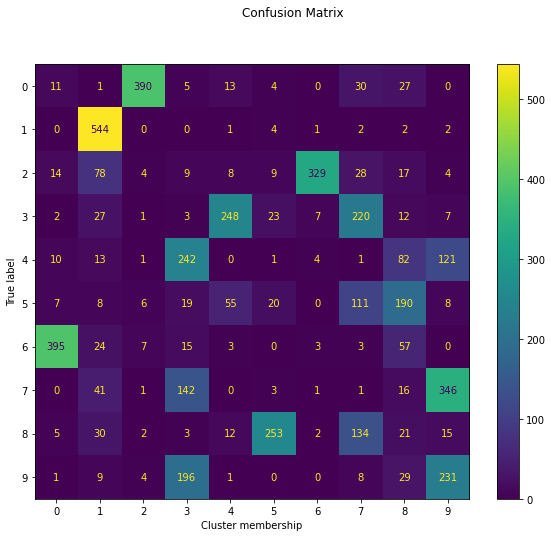

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, pred['kmeans-daskml'])
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.set_size_inches((10, 8))
disp.ax_.set_xlabel('Cluster membership');

In [ ]:
import numpy as np

for one in np.arange(10):
    counts = pd.Series(y_test[(pred['kmeans-daskml'] == one)].compute()).value_counts()
    print('Cluster', one, 'are mostly digit', counts.idxmax())

Cluster 0 are mostly digit 6
Cluster 1 are mostly digit 1
Cluster 2 are mostly digit 0
Cluster 3 are mostly digit 4
Cluster 4 are mostly digit 3
Cluster 5 are mostly digit 8
Cluster 6 are mostly digit 2
Cluster 7 are mostly digit 3
Cluster 8 are mostly digit 5
Cluster 9 are mostly digit 7


In [ ]:
def subset_images(X_, y_, cl_label_, digit, cluster):
    """
    subset images according to given digit label and cluster assignments

    X_: images
    y_: digit labels
    cl_label_: cluster "labels" (assignments)
    digit: digit label to subset
    cluster: cluster assingment to subset
    """
    cond = ((cl_label_ == cluster) & (y_ == digit)).compute()

    return X_[cond], y_[cond], cl_label_[cond]

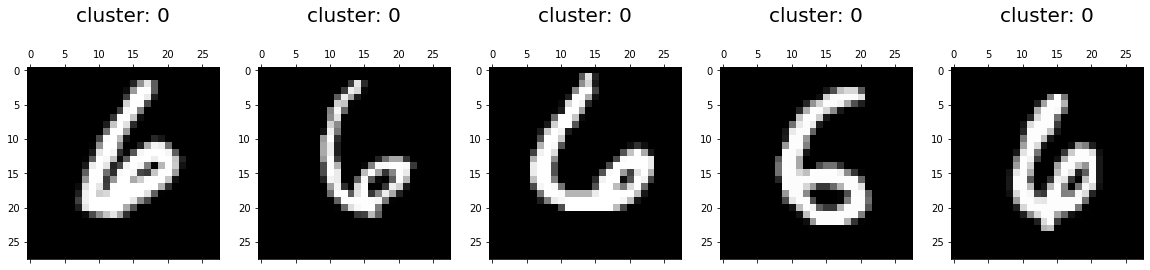

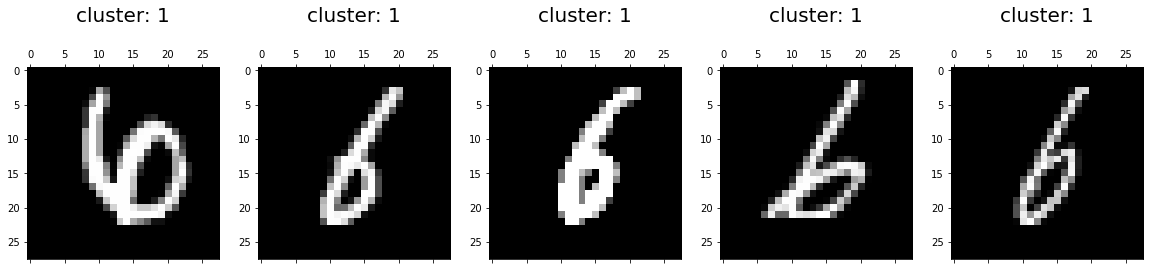

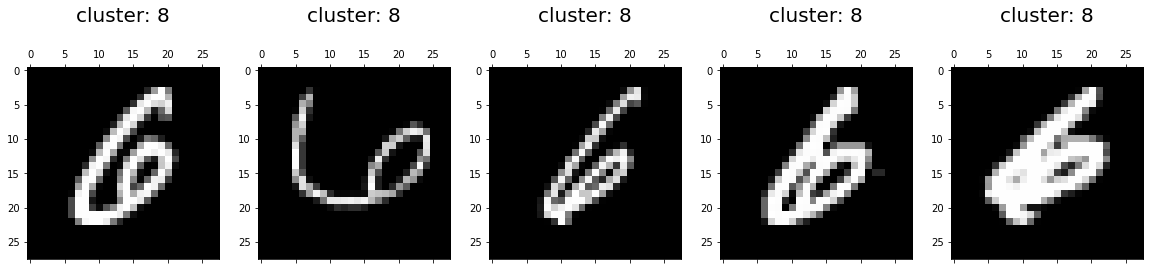

In [ ]:
# different types of digit 6
d, l, c = subset_images(X_test, y_test, pred['kmeans-daskml'], digit=6, cluster=0)
plot_digits(d, c, 5, 'cluster')
d, l, c = subset_images(X_test, y_test, pred['kmeans-daskml'], digit=6, cluster=1)
plot_digits(d, c, 5, 'cluster')
d, l, c = subset_images(X_test, y_test, pred['kmeans-daskml'], digit=6, cluster=8)
plot_digits(d, c, 5, 'cluster')

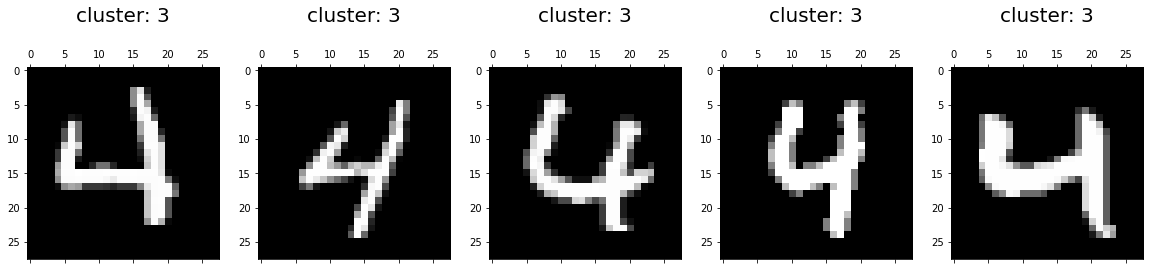

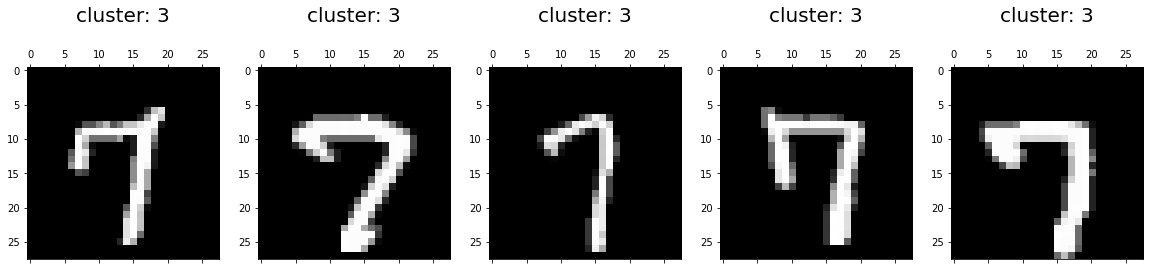

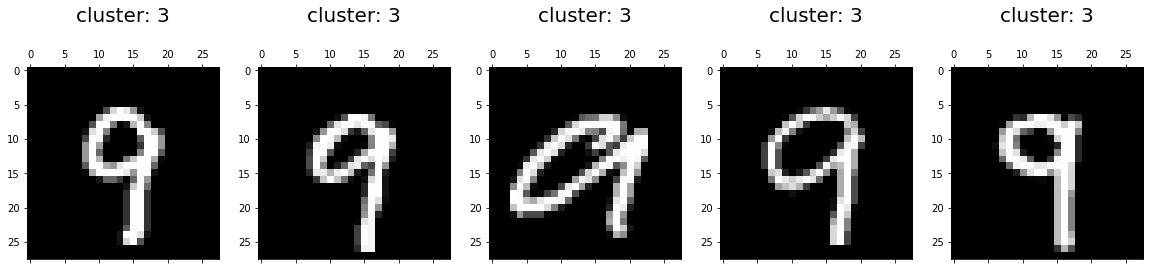

In [ ]:
# different types of digits 4, 7, 9 in cluster 3
d, l, c = subset_images(X_test, y_test, pred['kmeans-daskml'], digit=4, cluster=3)
plot_digits(d, c, 5, 'cluster')
d, l, c = subset_images(X_test, y_test, pred['kmeans-daskml'], digit=7, cluster=3)
plot_digits(d, c, 5, 'cluster')
d, l, c = subset_images(X_test, y_test, pred['kmeans-daskml'], digit=9, cluster=3)
plot_digits(d, c, 5, 'cluster')

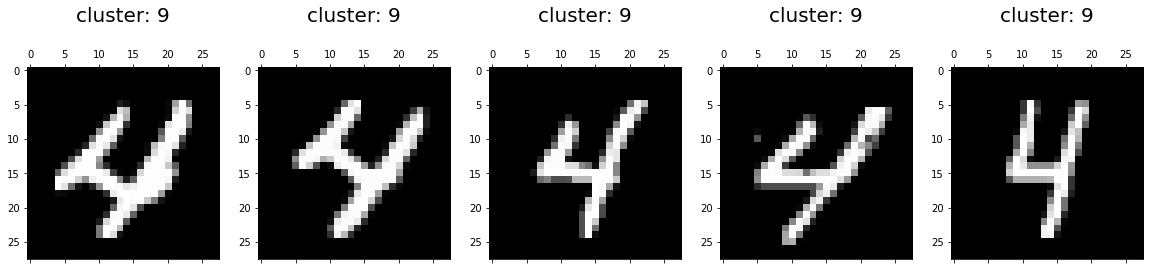

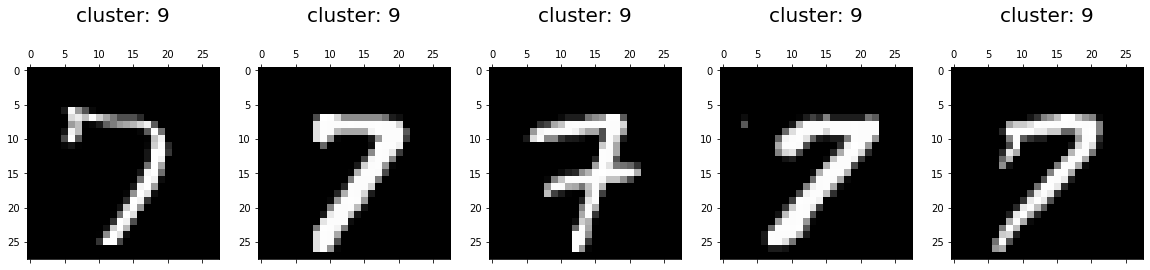

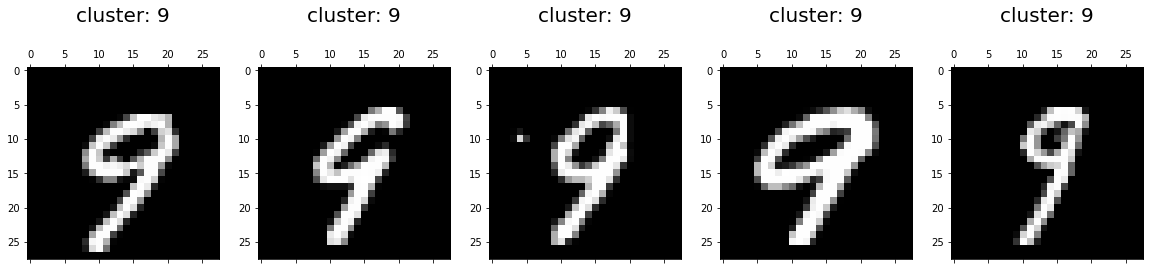

In [ ]:
# different types of digits 4, 7, 9 in cluster 9
d, l, c = subset_images(X_test, y_test, pred['kmeans-daskml'], digit=4, cluster=9)
plot_digits(d, c, 5, 'cluster')
d, l, c = subset_images(X_test, y_test, pred['kmeans-daskml'], digit=7, cluster=9)
plot_digits(d, c, 5, 'cluster')
d, l, c = subset_images(X_test, y_test, pred['kmeans-daskml'], digit=9, cluster=9)
plot_digits(d, c, 5, 'cluster')

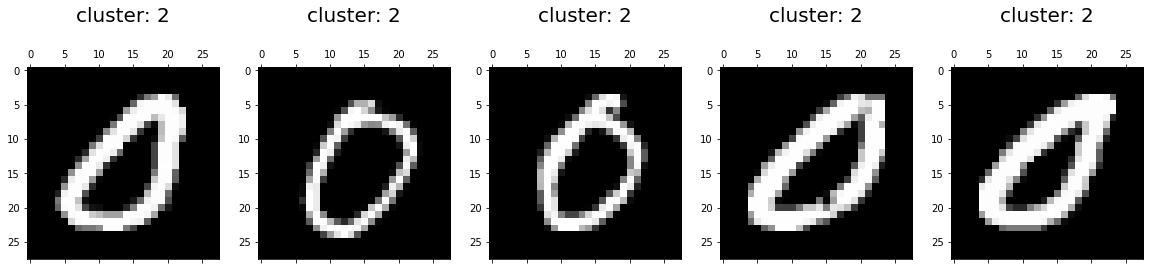

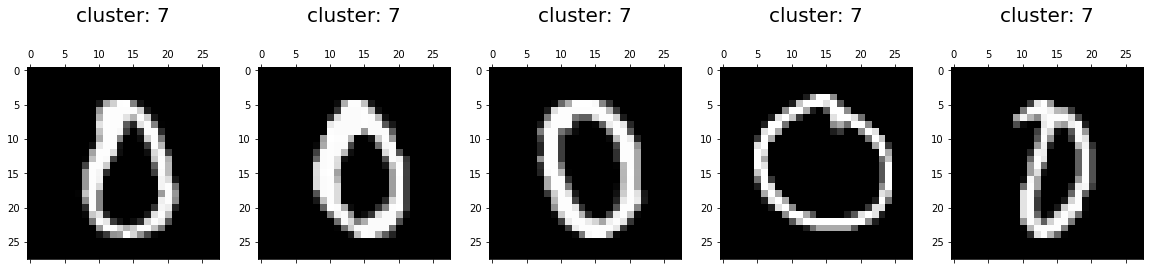

In [ ]:
# digit 0 in clusters 2, 7
d, l, c = subset_images(X_test, y_test, pred['kmeans-daskml'], digit=0, cluster=2)
plot_digits(d, c, 5, 'cluster')
d, l, c = subset_images(X_test, y_test, pred['kmeans-daskml'], digit=0, cluster=7)
plot_digits(d, c, 5, 'cluster')